## Using the NOAA API to pull basic weather information

In [2]:
import requests
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import time

import config

In [3]:
#API key is stored locally and ignored
noaa_token = config.noaa_api_key

#for authorization headers
head = {'Token': f'{noaa_token}'}

#San Diego International Airport
san_diego_station = 'GHCND:USW00023188'
station_id = san_diego_station

### Testing out the API with a few basic calls

In [4]:
datasets = requests.get('https://www.ncei.noaa.gov/cdo-web/api/v2/datasets', headers=head)

datasets.json()

{'metadata': {'resultset': {'offset': 1, 'count': 11, 'limit': 25}},
 'results': [{'uid': 'gov.noaa.ncdc:C00861',
   'mindate': '1763-01-01',
   'maxdate': '2023-11-27',
   'name': 'Daily Summaries',
   'datacoverage': 1,
   'id': 'GHCND'},
  {'uid': 'gov.noaa.ncdc:C00946',
   'mindate': '1763-01-01',
   'maxdate': '2023-11-01',
   'name': 'Global Summary of the Month',
   'datacoverage': 1,
   'id': 'GSOM'},
  {'uid': 'gov.noaa.ncdc:C00947',
   'mindate': '1763-01-01',
   'maxdate': '2023-01-01',
   'name': 'Global Summary of the Year',
   'datacoverage': 1,
   'id': 'GSOY'},
  {'uid': 'gov.noaa.ncdc:C00345',
   'mindate': '1991-06-05',
   'maxdate': '2023-11-29',
   'name': 'Weather Radar (Level II)',
   'datacoverage': 0.95,
   'id': 'NEXRAD2'},
  {'uid': 'gov.noaa.ncdc:C00708',
   'mindate': '1994-05-20',
   'maxdate': '2023-11-27',
   'name': 'Weather Radar (Level III)',
   'datacoverage': 0.95,
   'id': 'NEXRAD3'},
  {'uid': 'gov.noaa.ncdc:C00821',
   'mindate': '2010-01-01',
   

In [5]:
datasets = requests.get('https://www.ncei.noaa.gov/cdo-web/api/v2/datasets/GHCND', headers=head)

datasets.json()

{'mindate': '1763-01-01',
 'maxdate': '2023-11-27',
 'name': 'Daily Summaries',
 'datacoverage': 1,
 'id': 'GHCND'}

In [6]:
datacategories = requests.get('https://www.ncei.noaa.gov/cdo-web/api/v2/datacategories?limit=50',headers=head)

datacategories.json()

{'metadata': {'resultset': {'offset': 1, 'count': 42, 'limit': 50}},
 'results': [{'name': 'Annual Agricultural', 'id': 'ANNAGR'},
  {'name': 'Annual Degree Days', 'id': 'ANNDD'},
  {'name': 'Annual Precipitation', 'id': 'ANNPRCP'},
  {'name': 'Annual Temperature', 'id': 'ANNTEMP'},
  {'name': 'Autumn Agricultural', 'id': 'AUAGR'},
  {'name': 'Autumn Degree Days', 'id': 'AUDD'},
  {'name': 'Autumn Precipitation', 'id': 'AUPRCP'},
  {'name': 'Autumn Temperature', 'id': 'AUTEMP'},
  {'name': 'Computed', 'id': 'COMP'},
  {'name': 'Computed Agricultural', 'id': 'COMPAGR'},
  {'name': 'Degree Days', 'id': 'DD'},
  {'name': 'Dual-Pol Moments', 'id': 'DUALPOLMOMENT'},
  {'name': 'Echo Tops', 'id': 'ECHOTOP'},
  {'name': 'Evaporation', 'id': 'EVAP'},
  {'name': 'Hydrometeor Type', 'id': 'HYDROMETEOR'},
  {'name': 'Land', 'id': 'LAND'},
  {'name': 'Miscellany', 'id': 'MISC'},
  {'name': 'Other', 'id': 'OTHER'},
  {'name': 'Overlay', 'id': 'OVERLAY'},
  {'name': 'Precipitation', 'id': 'PRCP'},
 

In [7]:
#information about san diego
sandiego_station = requests.get(f'https://www.ncei.noaa.gov/cdo-web/api/v2/stations/{san_diego_station}', headers = head)

sandiego_station.json()

{'elevation': 4.6,
 'mindate': '1939-01-01',
 'maxdate': '2023-11-26',
 'latitude': 32.7336,
 'name': 'SAN DIEGO INTERNATIONAL AIRPORT, CA US',
 'datacoverage': 1,
 'id': 'GHCND:USW00023188',
 'elevationUnit': 'METERS',
 'longitude': -117.1831}

### Now we're going to pull weather data from San Diego

Data queries are limited to 1000 points of information. This functions pulls 6 months of data at a time for 4 variables, and that will stay below the limit.

In [8]:
def weather_puller(start_year, end_year):
    df = pd.DataFrame(columns = ['date', 'station', 'PRCP', 'TAVG', 'TMAX', 'TMIN'])

    while start_year <= end_year:
        year = start_year

        r_1sthalf = requests.get(f'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TAVG,TMAX,TMIN,PRCP&units=metric&limit=1000&stationid=GHCND:USW00023188&startdate={year}-01-01&enddate={year}-06-30', headers=head)
        r_2ndhalf = requests.get(f'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TAVG,TMAX,TMIN,PRCP&units=metric&limit=1000&stationid=GHCND:USW00023188&startdate={year}-07-01&enddate={year}-12-31', headers=head)

        df1 = pd.DataFrame(r_1sthalf.json()['results'])
        df2 = pd.DataFrame(r_2ndhalf.json()['results'])
        
        df1 = pd.pivot_table(df1, values = 'value', index=['date','station'], columns = 'datatype').reset_index()
        df2 = pd.pivot_table(df2, values = 'value', index=['date','station'], columns = 'datatype').reset_index()
        
        df = pd.concat([df,df1,df2], ignore_index=True)

        start_year += 1

        time.sleep(0.3)

    return df


In [9]:
sd_2018_2023 = weather_puller(2018,2023)

/var/folders/33/7q10ll617z94ljy4ck49zcrr0000gn/T/ipykernel_94075/238639362.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1,df2], ignore_index=True)


In [10]:
sd_2018_2023

,date,station,PRCP,TAVG,TMAX,TMIN
0,2018-01-01T00:00:00,GHCND:USW00023188,0.0,13.8,18.9,10.6
1,2018-01-02T00:00:00,GHCND:USW00023188,0.0,15.8,22.2,12.2
2,2018-01-03T00:00:00,GHCND:USW00023188,0.0,16.4,19.4,13.3
3,2018-01-04T00:00:00,GHCND:USW00023188,0.0,16.6,21.1,12.2
4,2018-01-05T00:00:00,GHCND:USW00023188,0.0,17.4,22.8,13.3
...,...,...,...,...,...,...
2151,2023-11-22T00:00:00,GHCND:USW00023188,0.0,17.2,25.6,10.0
2152,2023-11-23T00:00:00,GHCND:USW00023188,0.0,16.2,20.0,10.6
2153,2023-11-24T00:00:00,GHCND:USW00023188,0.3,17.4,18.9,12.8
2154,2023-11-25T00:00:00,GHCND:USW00023188,0.0,15.0,19.4,10.0


In [11]:
#convert the date to a datetime object
sd_2018_2023['date'] = pd.to_datetime(sd_2018_2023['date'])

### Checking the data to ensure plausible time capture

#### First look at daily temperature fluctations over an arbitrary multi-year period to see if it demonstrates any kind of cyclical or maybe sinusoidal behavior

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

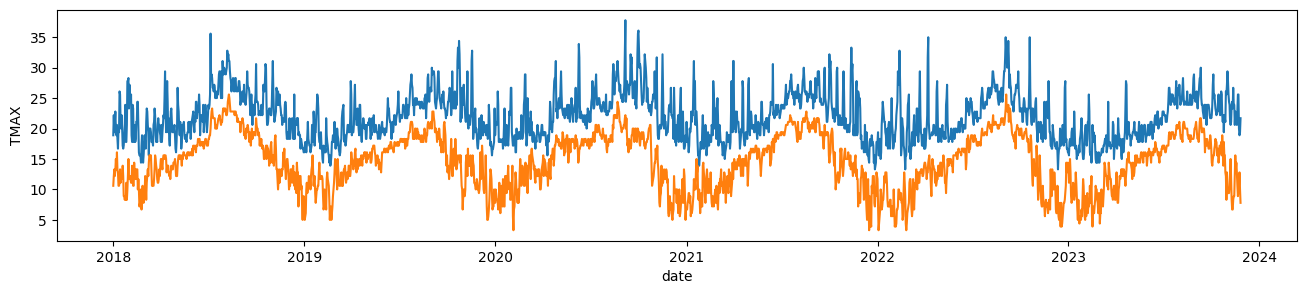

In [12]:
plt.figure(figsize=(16,3))
ax1 = sns.lineplot(data=sd_2018_2023, x='date', y='TMAX')
ax2 = sns.lineplot(data=sd_2018_2023, x='date', y='TMIN')

#### Next look at the daily temperature fluctuation, i.e. the difference between min temp and max temp

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Daily difference between TMAX and TMIN')

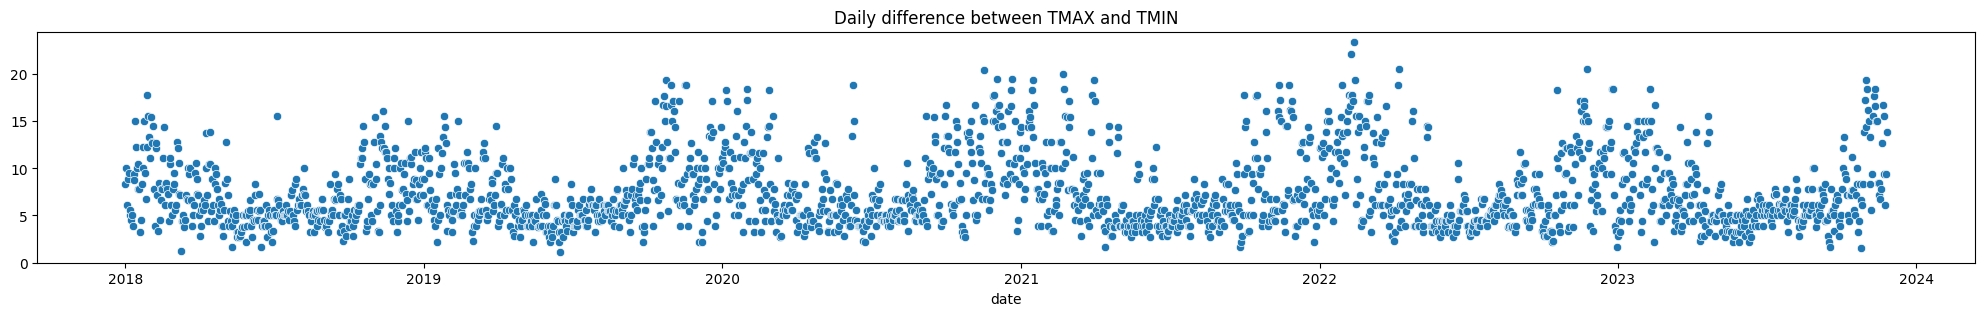

In [14]:
daily_temp_delta = sd_2018_2023['TMAX'] - sd_2018_2023['TMIN']

plt.figure(figsize=(25,3))
sns.scatterplot(x=sd_2018_2023['date'], y=daily_temp_delta)
plt.title("Daily difference between TMAX and TMIN")

#### Next look at 90-day rolling average for precipitation

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

<Axes: xlabel='date', ylabel='PRCP'>

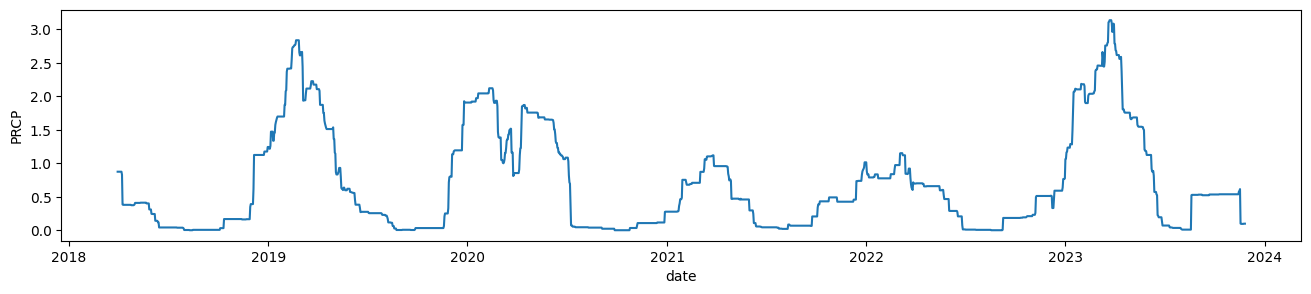

In [17]:
plt.figure(figsize=(16,3))
sns.lineplot(x=sd_2018_2023['date'], y=sd_2018_2023['PRCP'].rolling(90).mean())

In [18]:
sd_2018_2023.to_csv('sd_2018_2023.csv', index=False)